In [4]:
import re
import os
import pickle
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression  # Baseline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier, BalancedBaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, f1_score, make_scorer, \
                            plot_roc_curve, roc_auc_score, roc_curve, auc, plot_confusion_matrix
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
from itertools import cycle
from scipy import interp
%matplotlib inline

In [5]:
def save_as_pickle(f, fn):
    pth = os.path.join(os.getcwd(), 'Dataset', fn+'.pk')
    with open(pth, 'wb') as p:
        pickle.dump(f, p)

def load_from_pickle(fn):
    pth = os.path.join(os.getcwd(),  'Dataset', fn + '.pk')
    with open(pth, 'rb') as p:
        return pickle.load(p)

def load_pd_pickle(fn):
    pth = os.path.join(os.getcwd(), 'Dataset', fn + '.pk')
    return pd.read_pickle(pth)

In [6]:
y = load_from_pickle('y_classification')
# cols_classification = load_from_pickle('cols_classification_01')
cols_classification = load_from_pickle('y_cols_classification_005')
X = load_pd_pickle('X')
X = X[cols_classification]

In [7]:
X.shape

(3648, 127)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, shuffle=True)
X_train = X_train.reset_index().drop(['index'], axis=1)
X_test = X_test.reset_index().drop(['index'], axis=1)

In [10]:
def get_models():

    return [
                EasyEnsembleClassifier(),
                RandomForestClassifier(class_weight='balanced'),
                XGBClassifier(),
                SVC(kernel='linear', probability=True, class_weight='balanced'), 
                KNeighborsClassifier(),
                LogisticRegression(class_weight='balanced')
             ]
    
def train_models(X, y, n_splits):

    models = get_models()
    
    results_accuracy = {}
    results_precision = {}
    results_recall = {}
    results_f1 = {}
    results_roc = {}
    for model in models:
        name = str(model).split("(")[0]
        results_accuracy[name] = []
        results_precision[name] = []
        results_recall[name] = []
        results_f1[name] = []
        results_roc[name] = []
        
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for i, (t, v) in enumerate(cv.split(X, y)):
        
        X_train = X.loc[t]
        y_train = y[t]
        X_valid = X.loc[v]
        y_valid = y[v]
        
        for model in models:
            name = str(model).split("(")[0]
#             print('{} Starts.'.format(name))
            
            # Instantiate and fit Classification Model
            clf_model = model
            clf_model.fit(X_train, y_train)

            # Make predictions with model
            y_pred = clf_model.predict(X_valid)

            # precision_score, recall_score, accuracy_score, f1_score
            # Grab model name and store results associated with model

            results_accuracy[name].append(accuracy_score(y_valid, y_pred))
            results_precision[name].append(precision_score(y_valid, y_pred, average='macro'))
            results_recall[name].append(recall_score(y_valid, y_pred, average='macro'))
            results_f1[name].append(f1_score(y_valid, y_pred, average='macro'))
            results_roc[name].append(roc_auc_score(y_valid, clf_model.predict_proba(X_valid)[:, 1], average='macro'))
#             print('{} done.'.format(name))
    
    return  results_accuracy, results_precision, results_recall, results_f1, results_roc

def results(r):
    cols = ['Model', 'Accuracy Mean', 'Accuracy SD', 
            'Precision Mean', 'Precision SD', 
            'Recall Mean', 'Recall SD', 
            'F1 Mean', 'F1 SD', 
            'AUC Mean', 'AUC SD']   
    df = pd.DataFrame(columns = cols)
    models = get_models()
    for model in models:
        name = str(model).split("(")[0]
        row = {}
        row[cols[0]] = name
        for i, score in enumerate(r):
            s = np.array(score[name]).mean()
            st = np.array(score[name]).std()
            row[cols[2*i+1]] = str(round(s, 4))
            row[cols[2*i+2]] = str(round(st, 4))
        df = df.append(row, ignore_index = True)
    return df

In [ ]:
a = train_models(X_train, y_train, 10)

In [12]:
results(a)

,Model,Accuracy Mean,Accuracy SD,Precision Mean,Precision SD,Recall Mean,Recall SD,F1 Mean,F1 SD,AUC Mean,AUC SD
0,EasyEnsembleClassifier,0.7238,0.033,0.6893,0.026,0.7364,0.0292,0.6914,0.0317,0.7992,0.0255
1,RandomForestClassifier,0.7611,0.016,0.7092,0.0477,0.5763,0.0261,0.5731,0.0373,0.8052,0.0265
2,XGBClassifier,0.7786,0.0177,0.715,0.0297,0.663,0.0206,0.6781,0.0231,0.7905,0.0238
3,SVC,0.7214,0.0178,0.6797,0.017,0.7217,0.0213,0.6839,0.0181,0.7825,0.0253
4,KNeighborsClassifier,0.7485,0.0221,0.6572,0.049,0.5914,0.0329,0.5975,0.0408,0.703,0.0308
5,LogisticRegression,0.7265,0.025,0.682,0.0253,0.7222,0.032,0.6871,0.0268,0.7846,0.0257


In [19]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 20)]
# sampling_strategy = ['auto','majority', 'not minority', 'all']
replacement = ['True', 'False']

random_grid = {'n_estimators': n_estimators,
            #    'sampling_strategy': sampling_strategy,
               'replacement': replacement
               }

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
m = EasyEnsembleClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
m_random = RandomizedSearchCV(estimator = m, param_distributions = random_grid, n_iter = 100, cv = 10, scoring = 'balanced_accuracy', verbose=2, random_state=42, n_jobs=-1)
# Fit the random search model
m_random.fit(X_train, y_train)

In [22]:
best_random = m_random.best_estimator_
y_pred = best_random.predict(X_test)
accuracy_score(y_test, y_pred)


0.726027397260274

In [69]:
f1_score(y_test, y_pred, average='macro')


0.7061191626409018

In [70]:
precision_score(y_test, y_pred, average='macro')

0.7051516258677384

In [71]:
recall_score(y_test, y_pred, average='macro')

0.7414707568807339

Confusion matrix (n)
[[360 152]
 [ 48 170]]
Normalized confusion matrix (%)
[[0.7  0.3 ]
 [0.22 0.78]]


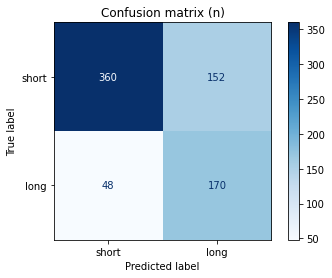

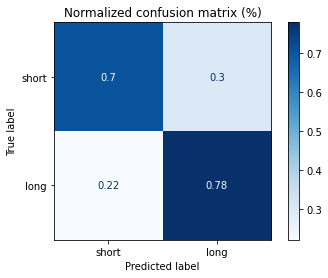

In [24]:
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix (n)", None),
                  ("Normalized confusion matrix (%)", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(best_random, X_test, y_test, display_labels=['short', 
#                                                                         'medium', 
                                                                        'long'], 
                          cmap=plt.cm.Blues, normalize=normalize)  
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

plt.show()

In [28]:
fi = np.mean([est.steps[1][1].feature_importances_ for est in best_random.estimators_], axis=0)
len(fi)

127

In [34]:
a, b = zip(*sorted(list(zip(fi, X.columns.to_list()))))
df = pd.DataFrame(b)
df_import_features = pd.DataFrame()
df_sorted = pd.DataFrame()
#df.columns=['imp','feature']
df['a'] = a
df.columns=['feature','imp']
df_sorted = df.sort_values(by=['imp'], ascending=False).copy()
df_import_features = df_sorted.iloc[0:10,:]
df_import_features

,feature,imp
126,lab_CREATININE,0.040
125,age_at_visit_years,0.032
124,lab_MEAN PLATELET VOLUME,0.030
123,lab_PHOSPHORUS,0.024
122,lab_CALCIUM,0.024
121,lab_VANCOMYCIN TROUGH,0.024
120,lab_TRIGLYCERIDES,0.022
119,lab_MEAN CORPUSCULAR HGB,0.022
118,lab_INTERNATIONAL NORMALIZED RATIO,0.022
117,lab_CREATINE KINASE,0.022


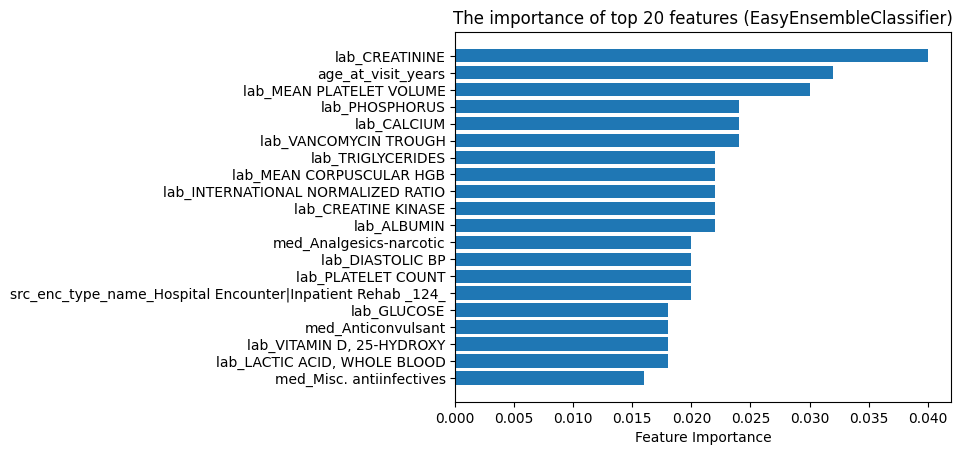

In [64]:
f = df_import_features['feature']
imp = df_import_features['imp']
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(f))
ax.barh(y_pos, imp, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(f)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature Importance')
ax.set_title('The importance of top 20 features (EasyEnsembleClassifier)')

plt.show()

In [58]:
f = df_import_features['feature']
imp = df_import_features['imp']
l = f.to_list()
l = [i.replace('lab_', '').replace('med_', '').replace('_', ' ') for i in l]
l

['CREATININE',
 'age at visit years',
 'MEAN PLATELET VOLUME',
 'PHOSPHORUS',
 'CALCIUM',
 'VANCOMYCIN TROUGH',
 'TRIGLYCERIDES',
 'MEAN CORPUSCULAR HGB',
 'INTERNATIONAL NORMALIZED RATIO',
 'CREATINE KINASE',
 'ALBUMIN',
 'Analgesics-narcotic',
 'DIASTOLIC BP',
 'PLATELET COUNT',
 'src enc type name Hospital Encounter|Inpatient Rehab  124 ',
 'GLUCOSE',
 'Anticonvulsant',
 'VITAMIN D, 25-HYDROXY',
 'LACTIC ACID, WHOLE BLOOD',
 'Misc. antiinfectives']

In [61]:
l = ['CREATININE',
 'age at visit years',
 'MEAN PLATELET VOLUME',
 'PHOSPHORUS',
 'CALCIUM',
 'VANCOMYCIN TROUGH',
 'TRIGLYCERIDES',
 'MEAN CORPUSCULAR HGB',
 'INTERNATIONAL NORMALIZED RATIO',
 'CREATINE KINASE',
 'ALBUMIN',
 'Analgesics-narcotic',
 'DIASTOLIC BP',
 'PLATELET COUNT',
 'Hospital Encounter (Rehabilitation)',
 'GLUCOSE',
 'Anticonvulsant',
 'VITAMIN D, 25-HYDROXY',
 'LACTIC ACID, WHOLE BLOOD',
 'Misc. antiinfectives']

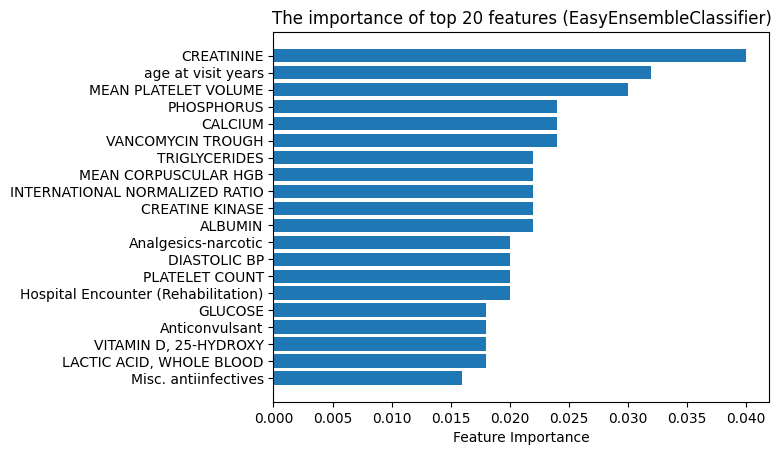

In [65]:

plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(l))
ax.barh(y_pos, imp, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(l)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature Importance')
ax.set_title('The importance of top 20 features (EasyEnsembleClassifier)')

plt.show()

# ROC

In [72]:
y_score = best_random.predict_proba(X_test)
pos_probs = y_score[:, 1]
fpr, tpr, _ = roc_curve(y_test, pos_probs)
roc_score = roc_auc_score(y_test, pos_probs, average='macro')

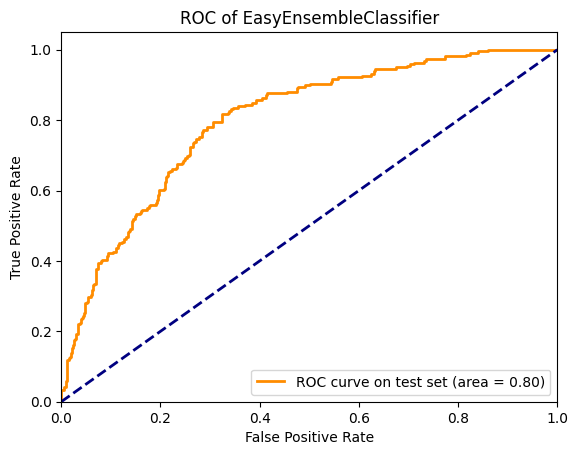

In [73]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve on test set (area = %0.2f)' % roc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of EasyEnsembleClassifier')
plt.legend(loc="lower right")
plt.show()

In [ ]:
l = ['short', 'long']

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(l[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [54]:
eta = [0.05, 0.1, 0.5]
gamma = [0, 0.5, 2, 5, 10]
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# max_depth = [int(x) for x in np.linspace(0, 50, num = 10)]
# min_child_weight = [0, 1, 5, 10, 25]
subsample = [0.2, 0.5, 0.8, 1]
weights = [1, 10, 25, 50, 75, 99, 100, 1000]
# Create the random grid
random_grid = {'eta': eta,
               'gamma': gamma,
               'n_estimators': n_estimators,
            #    'max_depth': max_depth,
            #    'min_child_weight': min_child_weight,
            #    'subsample': subsample,
               'scale_pos_weight': weights
               }

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
model = XGBClassifier(use_label_encoder=False)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42)
# Fit the random search model
model_random.fit(X_train, y_train)

In [56]:
model_random.best_params_
best_random = model_random.best_estimator_
y_pred = best_random.predict(X_test)
accuracy_score(y_test, y_pred)

/users/home/jwu51/.conda/envs/py38/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.7835616438356164

In [57]:
f1_score(y_test, y_pred, average='macro')
# roc_auc_score(y_test, best_random.predict_proba(X_test)[:, 1])

0.6983439517099248

In [48]:
criterion = ['gini', 'entropy']
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
sampling_strategy = ['auto','majority', 'not minority', 'all']
class_weight = ['balanced', 'balanced_subsample']
# Create the random grid

random_grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'sampling_strategy': sampling_strategy
               }

In [17]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
m = BalancedRandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
m_random = RandomizedSearchCV(estimator = m, param_distributions = random_grid, n_iter = 100, cv = 5, scoring = 'balanced_accuracy', verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
m_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample',
                                                         {0: 0.5, 1: 5},
                                                         {0: 1, 1: 4}],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                             

In [37]:
best_random = m_random.best_estimator_
y_pred = best_random.predict(X_test)
print(accuracy_score(y_test, y_pred))
f1_score(y_test, y_pred, average='macro')

0.7301369863013699


0.7029081165725666

Confusion matrix (n)
[[377 135]
 [ 62 156]]
Normalized confusion matrix (%)
[[0.74 0.26]
 [0.28 0.72]]


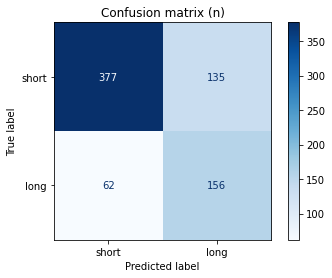

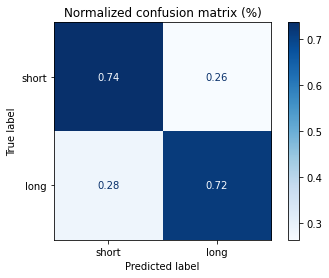

In [39]:
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix (n)", None),
                  ("Normalized confusion matrix (%)", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(best_random, X_test, y_test, display_labels=['short', 
#                                                                         'medium', 
                                                                        'long'], 
                          cmap=plt.cm.Blues, normalize=normalize)  
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

plt.show()

# Feature selection


In [41]:
features_names = X.columns

In [47]:
best_random.base_estimator_['classifier'].feature_importances_

AttributeError: 'AdaBoostClassifier' object has no attribute 'estimators_'

In [42]:
importance = best_random.feature_importances_
a, b = zip(*sorted(list(zip(importance, features_names))))
df = pd.DataFrame(b)
df_import_features = pd.DataFrame()
df_sorted = pd.DataFrame()
#df.columns=['imp','feature']
df['a'] = a
df.columns=['feature','imp']
df_sorted = df.sort_values(by=['imp'], ascending=False).copy()
df_import_features = df_sorted.iloc[0:20,:]
df_import_features

AttributeError: 'EasyEnsembleClassifier' object has no attribute 'feature_importances_'

In [66]:
f = df_import_features['feature']
imp = df_import_features['imp']
# imp = np.array(df_import_features['imp'])
# imp_norm = imp / np.linalg.norm(imp)

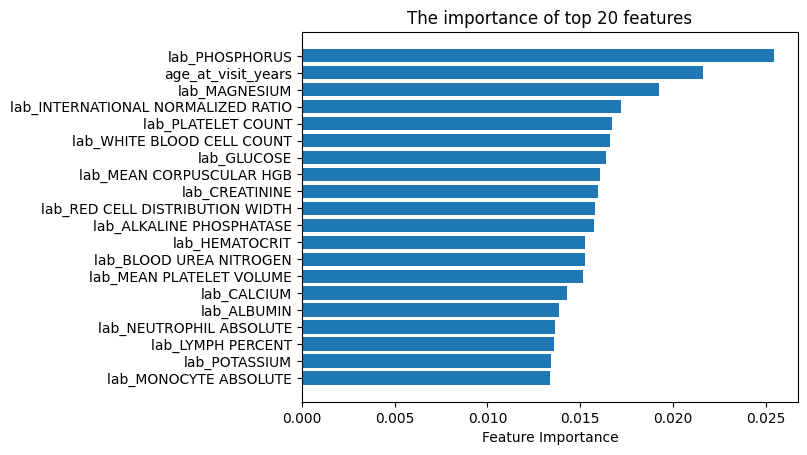

In [67]:
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(f))
ax.barh(y_pos, imp, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(f)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature Importance')
ax.set_title('The importance of top 20 features')

plt.show()

In [40]:
y_test = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test.shape[1]
y_score = best_random.predict_proba(X_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

IndexError: index 2 is out of bounds for axis 1 with size 2

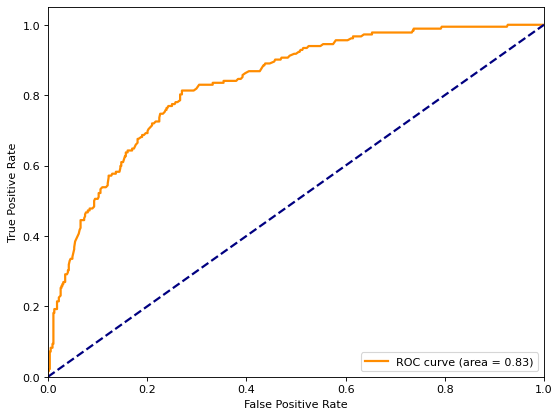

In [78]:
plt.figure(figsize=(8, 6), dpi=80)
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

/tmp/ipykernel_13943/445635976.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


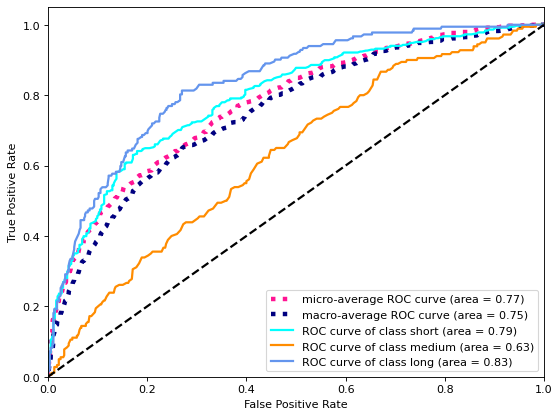

In [80]:
l = ['short', 'long']

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(l[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [74]:
cc = X.columns.tolist()
[k for k in cc if 'sex' in k]

[]